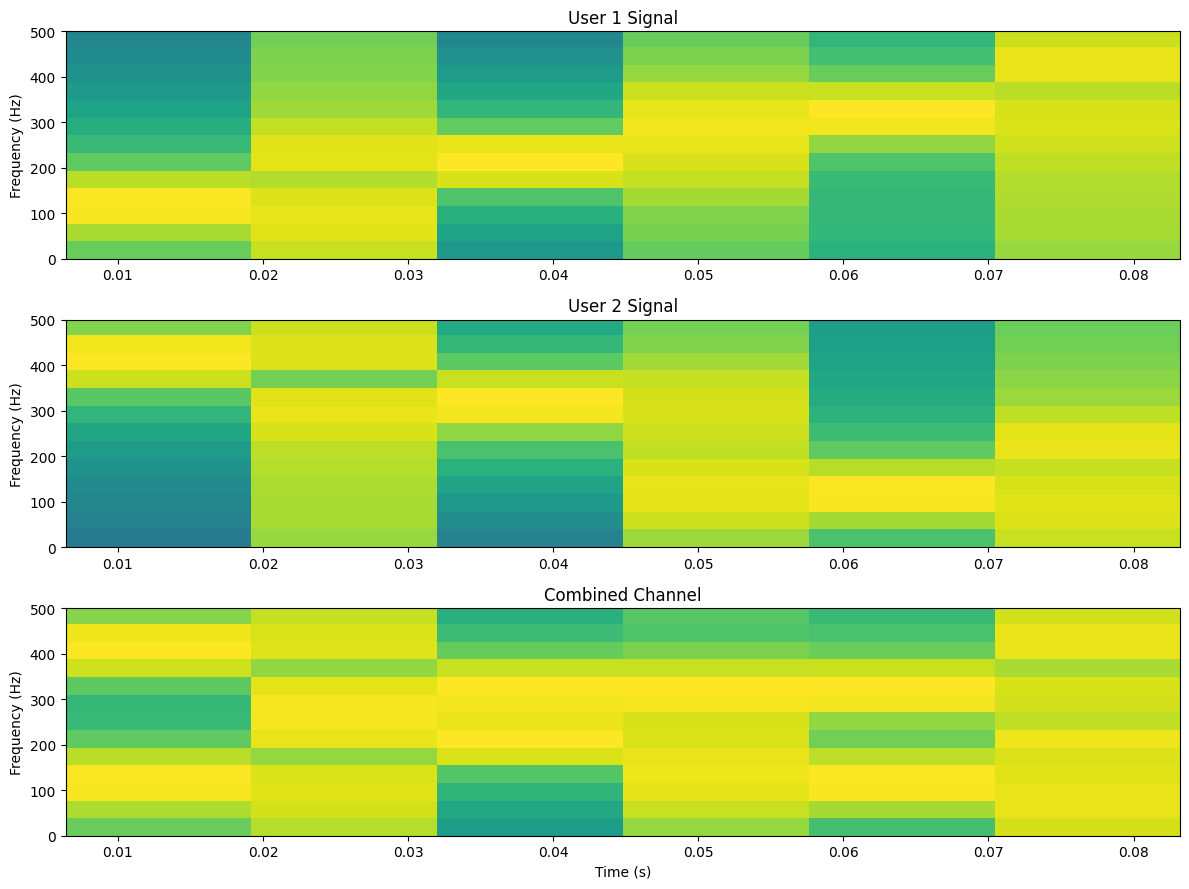

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_fhss_cdma():
    duration = 0.1
    sample_rate = 10000
    t = np.linspace(0, duration, int(duration * sample_rate))

    # Different hopping patterns for two users
    hop_pattern1 = [100, 200, 300, 400]  # User 1
    hop_pattern2 = [400, 300, 100, 200]  # User 2

    hop_duration = duration/4
    samples_per_hop = int(hop_duration * sample_rate)

    # Generate signals for both users
    signal1 = np.zeros_like(t)
    signal2 = np.zeros_like(t)

    for i in range(4):
        start_idx = i * samples_per_hop
        end_idx = (i + 1) * samples_per_hop

        signal1[start_idx:end_idx] = np.sin(2*np.pi*hop_pattern1[i]*t[start_idx:end_idx])
        signal2[start_idx:end_idx] = np.sin(2*np.pi*hop_pattern2[i]*t[start_idx:end_idx])

    # Combined channel
    combined = signal1 + signal2

    plt.figure(figsize=(12, 9))

    plt.subplot(311)
    plt.specgram(signal1, Fs=sample_rate, NFFT=256)
    plt.title('User 1 Signal')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(0, 500)

    plt.subplot(312)
    plt.specgram(signal2, Fs=sample_rate, NFFT=256)
    plt.title('User 2 Signal')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(0, 500)

    plt.subplot(313)
    plt.specgram(combined, Fs=sample_rate, NFFT=256)
    plt.title('Combined Channel')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(0, 500)

    plt.tight_layout()
    plt.show()

simulate_fhss_cdma()

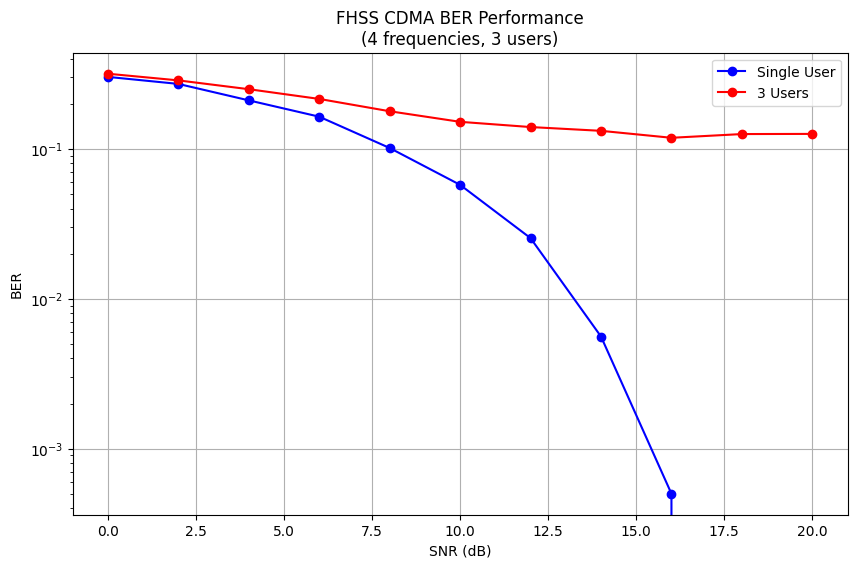

At SNR=10dB:
Single user BER: 5.76e-02
Multi-user BER: 1.52e-01


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_cdma_ber():
    n_bits = 10000
    n_users = 3
    hop_freqs = [100, 200, 300, 400]
    L = len(hop_freqs)
    SNR_dB = np.arange(0, 21, 2)

    ber_single = []  # Single user
    ber_multi = []   # Multiple users

    for snr_db in SNR_dB:
        snr = 10**(snr_db/10)
        noise_power = 1/snr

        # Single user
        errors_single = 0
        # Multi user
        errors_multi = 0

        transmitted_bits = np.random.randint(0, 2, n_bits)

        for i in range(n_bits):
            # Generate hopping patterns for all users
            user_freqs = [np.random.choice(hop_freqs) for _ in range(n_users)]

            # Single user case
            noise = np.random.normal(0, np.sqrt(noise_power))
            received_single = transmitted_bits[i] + noise
            detected_single = 1 if received_single > 0.5 else 0
            if detected_single != transmitted_bits[i]:
                errors_single += 1

            # Multi user case - consider MAI
            collisions = sum(1 for f in user_freqs[1:] if f == user_freqs[0])
            interference = collisions * 0.5  # MAI from colliding users
            received_multi = transmitted_bits[i] + noise + interference
            detected_multi = 1 if received_multi > 0.5 else 0
            if detected_multi != transmitted_bits[i]:
                errors_multi += 1

        ber_single.append(errors_single/n_bits)
        ber_multi.append(errors_multi/n_bits)

    plt.figure(figsize=(10, 6))
    plt.semilogy(SNR_dB, ber_single, 'b-o', label=f'Single User')
    plt.semilogy(SNR_dB, ber_multi, 'r-o', label=f'{n_users} Users')
    plt.grid(True)
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.title(f'FHSS CDMA BER Performance\n({L} frequencies, {n_users} users)')
    plt.legend()
    plt.show()

    print(f"At SNR=10dB:")
    print(f"Single user BER: {ber_single[5]:.2e}")
    print(f"Multi-user BER: {ber_multi[5]:.2e}")

simulate_cdma_ber()

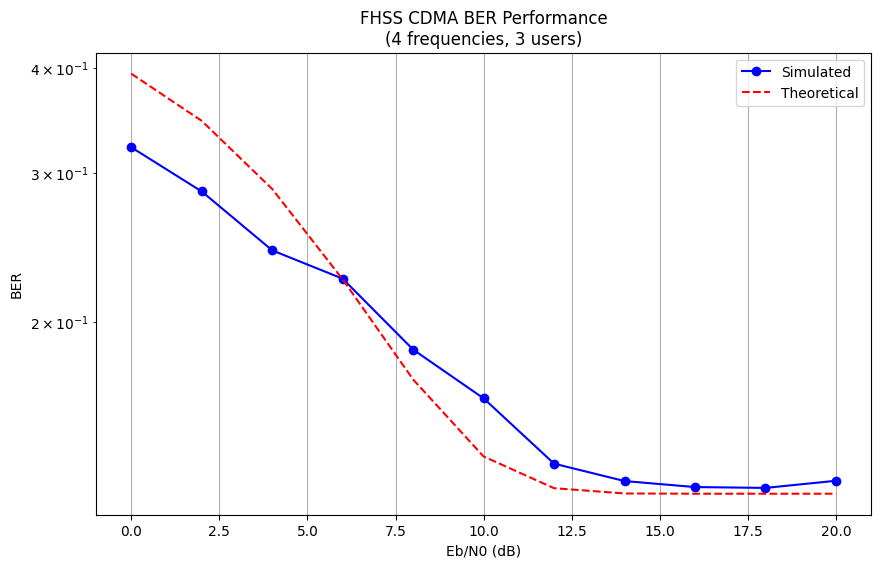

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def theoretical_ber_cdma_fhss(EbN0_dB, L, K):
    """
    L: number of frequency channels
    K: number of users
    """
    EbN0 = 10**(EbN0_dB/10)
    # Probability of frequency collision
    Pc = 1/L
    # Average number of interferers
    I = (K-1) * Pc
    # BER considering both AWGN and MAI
    Pb = ((L-1)/L) * 0.5 * np.exp(-EbN0/(2*(1+I))) + (1/L) * 0.5
    return Pb

def simulate_cdma_ber():
    n_bits = 10000
    n_users = 3
    hop_freqs = [100, 200, 300, 400]
    L = len(hop_freqs)
    EbN0_dB = np.arange(0, 21, 2)

    ber_simulated = []
    ber_theoretical = []

    for snr_db in EbN0_dB:
        snr = 10**(snr_db/10)
        noise_power = 1/snr
        errors = 0

        for i in range(n_bits):
            user_freqs = [np.random.choice(hop_freqs) for _ in range(n_users)]
            collisions = sum(1 for f in user_freqs[1:] if f == user_freqs[0])

            noise = np.random.normal(0, np.sqrt(noise_power))
            interference = collisions * 0.5

            transmitted_bit = np.random.randint(0, 2)
            received = transmitted_bit + noise + interference
            detected = 1 if received > 0.5 else 0

            if detected != transmitted_bit:
                errors += 1

        ber_simulated.append(errors/n_bits)
        ber_theoretical.append(theoretical_ber_cdma_fhss(snr_db, L, n_users))

    plt.figure(figsize=(10, 6))
    plt.semilogy(EbN0_dB, ber_simulated, 'b-o', label='Simulated')
    plt.semilogy(EbN0_dB, ber_theoretical, 'r--', label='Theoretical')
    plt.grid(True)
    plt.xlabel('Eb/N0 (dB)')
    plt.ylabel('BER')
    plt.title(f'FHSS CDMA BER Performance\n({L} frequencies, {n_users} users)')
    plt.legend()
    plt.show()

simulate_cdma_ber()

## Asynchronous FHSS

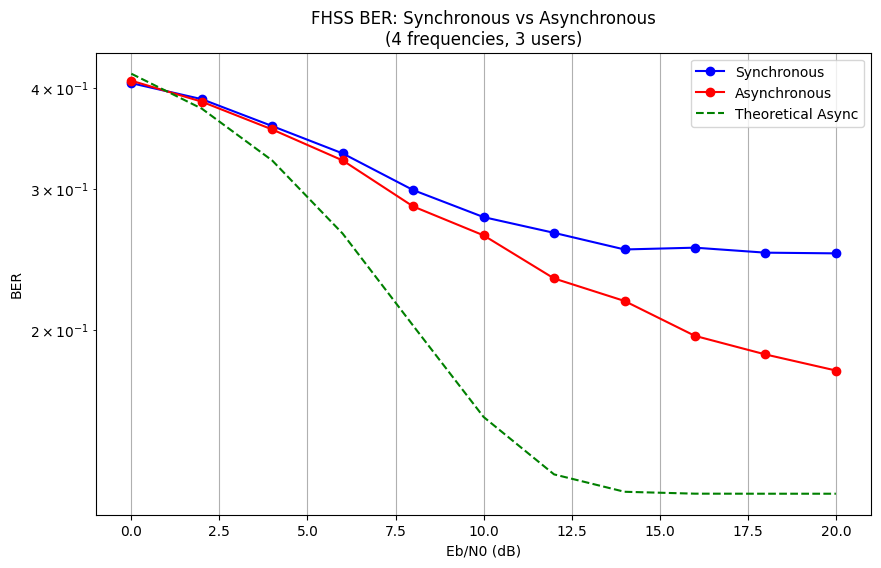

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def theoretical_ber_async_fhss(EbN0_dB, L, K):
    EbN0 = 10**(EbN0_dB/10)
    I = (K-1)/L
    return ((L-1)/L) * 0.5 * np.exp(-EbN0/(2*(1+2*I))) + (1/L) * 0.5

def simulate_async_fhss():
    n_bits = 10000
    n_users = 3
    L = 4  # frequencies
    EbN0_dB = np.arange(0, 21, 2)

    ber_sync = []
    ber_async = []
    ber_theoretical = []

    # Random time offsets for async users (0-1 hop duration)
    time_offsets = np.random.random(n_users-1)

    for snr_db in EbN0_dB:
        snr = 10**(snr_db/10)
        noise_power = 1/snr
        errors_sync = 0
        errors_async = 0

        for i in range(n_bits):
            # Synchronous case
            user_freqs_sync = np.random.randint(0, L, n_users)
            collisions_sync = sum(user_freqs_sync[1:] == user_freqs_sync[0])

            # Asynchronous case - consider partial overlaps
            user_freqs_async1 = np.random.randint(0, L, n_users)
            user_freqs_async2 = np.random.randint(0, L, n_users)  # Next hop
            collisions_async = 0

            for j in range(1, n_users):
                # Partial overlap calculation
                if user_freqs_async1[j] == user_freqs_async1[0]:
                    collisions_async += (1 - time_offsets[j-1])
                if user_freqs_async2[j] == user_freqs_async1[0]:
                    collisions_async += time_offsets[j-1]

            noise = np.random.normal(0, np.sqrt(noise_power))

            # Synchronous detection
            received_sync = 1 + noise - 0.5 * collisions_sync
            detected_sync = received_sync > 0.5
            errors_sync += detected_sync != 1

            # Asynchronous detection
            received_async = 1 + noise - 0.5 * collisions_async
            detected_async = received_async > 0.5
            errors_async += detected_async != 1

        ber_sync.append(errors_sync/n_bits)
        ber_async.append(errors_async/n_bits)
        ber_theoretical.append(theoretical_ber_async_fhss(snr_db, L, n_users))

    plt.figure(figsize=(10, 6))
    plt.semilogy(EbN0_dB, ber_sync, 'b-o', label='Synchronous')
    plt.semilogy(EbN0_dB, ber_async, 'r-o', label='Asynchronous')
    plt.semilogy(EbN0_dB, ber_theoretical, 'g--', label='Theoretical Async')
    plt.grid(True)
    plt.xlabel('Eb/N0 (dB)')
    plt.ylabel('BER')
    plt.title(f'FHSS BER: Synchronous vs Asynchronous\n({L} frequencies, {n_users} users)')
    plt.legend()
    plt.show()

simulate_async_fhss()

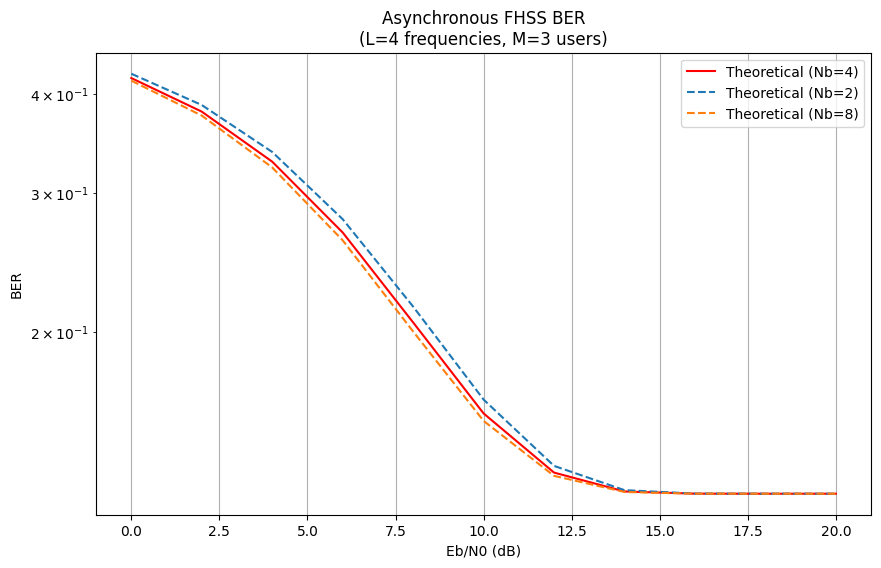

Hit probability for L=4, M=3, Nb=8: 0.483


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def hit_probability_async(L, M, Nb):
    """Calculate hit probability for asynchronous FHSS"""
    return 1 - (1 - (1/L) * (1 + 1/Nb))**(M-1)

def theoretical_ber_async_fhss(EbN0_dB, L, M, Nb):
    EbN0 = 10**(EbN0_dB/10)
    Ph = hit_probability_async(L, M, Nb)
    return ((L-1)/L) * 0.5 * np.exp(-EbN0/(2*(1+2*Ph))) + (1/L) * 0.5

def simulate_async_fhss():
    L = 4       # Number of frequencies
    M = 3       # Number of users
    Nb = 4      # Hops per bit
    EbN0_dB = np.arange(0, 21, 2)

    ber_theoretical = [theoretical_ber_async_fhss(snr, L, M, Nb) for snr in EbN0_dB]

    plt.figure(figsize=(10, 6))
    plt.semilogy(EbN0_dB, ber_theoretical, 'r-', label=f'Theoretical (Nb={Nb})')

    # Compare different Nb values
    for Nb in [2, 8]:
        ber = [theoretical_ber_async_fhss(snr, L, M, Nb) for snr in EbN0_dB]
        plt.semilogy(EbN0_dB, ber, '--', label=f'Theoretical (Nb={Nb})')

    plt.grid(True)
    plt.xlabel('Eb/N0 (dB)')
    plt.ylabel('BER')
    plt.title(f'Asynchronous FHSS BER\n(L={L} frequencies, M={M} users)')
    plt.legend()
    plt.show()

    Ph = hit_probability_async(L, M, Nb)
    print(f"Hit probability for L={L}, M={M}, Nb={Nb}: {Ph:.3f}")

simulate_async_fhss()